<a href="https://colab.research.google.com/github/jaxoncannon/guessing_nans/blob/main/Final_data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np


happiness_url = "https://raw.githubusercontent.com/jaxoncannon/guessing_nans/main/hapiscore_whr.csv"
cell_phones_url = "https://raw.githubusercontent.com/jaxoncannon/guessing_nans/main/cell_phones_per_100_people.csv"
democracy_url = "https://raw.githubusercontent.com/jaxoncannon/guessing_nans/main/democracy_score_use_as_color.csv"
human_dev_url = "https://raw.githubusercontent.com/jaxoncannon/guessing_nans/main/hdi_human_development_index.csv"
internet_url = "https://raw.githubusercontent.com/jaxoncannon/guessing_nans/main/internet_users.csv"
murders_url = "https://raw.githubusercontent.com/jaxoncannon/guessing_nans/main/murder_per_100000_people.csv"
women_in_gov_url = "https://raw.githubusercontent.com/jaxoncannon/guessing_nans/main/wn_bothhouses_c.csv"

happiness = pd.read_csv(happiness_url)
cell_phones = pd.read_csv(cell_phones_url)
democracy = pd.read_csv(democracy_url)
human_dev = pd.read_csv(human_dev_url)
internet = pd.read_csv(internet_url)
murders = pd.read_csv(murders_url)
women_in_gov = pd.read_csv(women_in_gov_url)

In [ ]:
#need to cut up dataframes to cover only the same countries and timeframe

def find_common_years_and_countries(df_list):

    # get min and max years 
    min_years = []
    max_years = []
    for df in df_list:
        min_years.append(df.columns[1:].min())
        max_years.append(df.columns[1:].max())
    
    # find overlapping year range
    start_year = max(min_years)
    end_year = min(max_years)
    
    # find common set of countries
    common_countries = set(df_list[0]['country'])
    for df in df_list:
        common_countries = common_countries.intersection(df['country'])
    
    # cut to only include overlapping year range and common countries
    new_df_list = []
    for df in df_list:
        new_df = df.loc[df['country'].isin(common_countries), ['country']]
        for col in df.columns:
            if col >= start_year and col <= end_year:
                new_df[col] = df.loc[df['country'].isin(common_countries), col]
        new_df_list.append(new_df)
    
    return new_df_list

In [ ]:
dataframes = [happiness, cell_phones, democracy, human_dev, internet, murders, women_in_gov]
overlapping_dataframes = find_common_years_and_countries(dataframes)

In [ ]:
#resetting indices
for count, i in enumerate(overlapping_dataframes):
  overlapping_dataframes[count] = overlapping_dataframes[count].reset_index(drop=True)

In [ ]:
#keeping track of what variables the dataframes represent
overlapping_dataframes[0]['var'] = 'happiness'
overlapping_dataframes[1]['var'] = 'cell_phones'
overlapping_dataframes[2]['var'] = 'democracy'
overlapping_dataframes[3]['var'] = 'human_dev'
overlapping_dataframes[4]['var'] = 'internet'
overlapping_dataframes[5]['var'] = 'murders'
overlapping_dataframes[6]['var'] = 'women_in_gov'

In [ ]:
#combining to create master dataframe and resetting indices again
master_df = pd.concat(overlapping_dataframes)
master_df = master_df.reset_index(drop=True)

In [ ]:
#making sure that datatypes makes sense
def datatype_fixer(df):
  df['country'] = df['country'].astype('string')
  df['2004'] = pd.to_numeric(df['2004'], errors='coerce')
  df['2005'] = pd.to_numeric(df['2005'], errors='coerce')
  df['2006'] = pd.to_numeric(df['2006'], errors='coerce')
  df['2007'] = pd.to_numeric(df['2007'], errors='coerce')
  df['2008'] = pd.to_numeric(df['2008'], errors='coerce')
  df['2009'] = pd.to_numeric(df['2009'], errors='coerce')
  df['2010'] = pd.to_numeric(df['2010'], errors='coerce')
  df['var'] = df['var'].astype('string')
  return df

In [ ]:
master_df = datatype_fixer(master_df)

In [ ]:
master_df

,country,2004,2005,2006,2007,2008,2009,2010,var
0,Albania,NaN,NaN,46.30,NaN,54.90,52.7,58.70,happiness
1,Argentina,NaN,63.10,60.70,59.60,64.20,64.4,67.80,happiness
2,Armenia,NaN,42.90,48.80,46.50,41.80,43.7,42.60,happiness
3,Australia,73.40,NaN,72.80,72.50,NaN,74.5,74.10,happiness
4,Austria,NaN,71.20,NaN,71.80,NaN,73.0,74.70,happiness
...,...,...,...,...,...,...,...,...,...
583,Trinidad and Tobago,30.30,31.80,33.30,31.50,29.60,27.8,28.50,women_in_gov
584,Tunisia,13.40,14.00,14.60,15.20,27.60,26.9,26.50,women_in_gov
585,Turkey,7.21,8.16,9.11,10.40,11.70,12.9,14.20,women_in_gov
586,Ukraine,6.67,7.11,8.33,8.45,8.61,8.8,9.07,women_in_gov


In [ ]:
def normalize_variables(master_df):
    normalized_master_df = master_df.copy()
    variables = ['happiness', 'cell_phones', 'democracy', 'human_dev', 'internet', 'murders', 'women_in_gov']
    scaling_factors = {}

    for variable in variables:
        # Select rows corresponding to the current variable
        rows = (normalized_master_df.iloc[:, -1] == variable)

        # Select only numeric columns (ignoring the first and last columns)
        columns = normalized_master_df.loc[rows].iloc[:, 1:-1].select_dtypes(include=np.number).columns

        # Normalize values of the selected rows and columns
        min_value = normalized_master_df.loc[rows, columns].min().min()
        max_value = normalized_master_df.loc[rows, columns].max().max()
        scaling_factors[variable] = (min_value, max_value)
        normalized_master_df.loc[rows, columns] = (normalized_master_df.loc[rows, columns] - min_value) / (max_value - min_value)

    return normalized_master_df, scaling_factors

In [ ]:
master_df, scaling_factors = normalize_variables(master_df)

In [ ]:
#create the training set by dropping values randomly
# also leaves original df unchanged while creating a key for later
def dropper(unchanged):
    # make copies
    changed = unchanged.copy()
    country_keeper = changed["country"].copy()
    var_keeper = changed["var"].copy()

    # set proportion of dropped values
    probability = 0.2

    # keep log of what is dropped
    key = pd.DataFrame(False, index=changed.index, columns=changed.columns)

    # drop stuff
    for i, row in changed.iterrows():
        # check for missing values
        non_missing_mask = ~row.isnull()
        # apply dropping logic only to non-missing values
        non_missing_mask &= (np.random.rand(*row.shape) < probability)
        key.loc[i, non_missing_mask] = True
        changed.loc[i, non_missing_mask] = np.nan

    # make sure it doesn't drop the important stuff
    changed["country"] = country_keeper
    changed["var"] = var_keeper
    key["country"] = country_keeper
    key["var"] = var_keeper

    return changed, key

In [ ]:
training_set, key = dropper(master_df)

In [ ]:
#some rows don't contain any information, so there's no point keeping them
def remove_nan_rows(training_df, master_df, key_df):
    # Create a mask for rows containing only NaN values in the training_df
    mask = training_df.iloc[:, 1:-1].isna().all(axis=1)

    # Invert the mask to get rows that contain at least one non-NaN value
    valid_rows = ~mask

    # Apply the mask to all three dataframes
    cleaned_training_df = training_df[valid_rows]
    cleaned_master_df = master_df[valid_rows]
    cleaned_key_df = key_df[valid_rows]

    return cleaned_training_df, cleaned_master_df, cleaned_key_df

In [ ]:
training_set, master_df, key = remove_nan_rows(training_set, master_df, key)
training_set = training_set.reset_index(drop=True)
master_df = master_df.reset_index(drop=True)
key = key.reset_index(drop=True)

In [ ]:
#function for scoring models
def compare_dataframes(master_df, filled_df, key_df):
    diff_sum = 0
    n_of_nans = 0
    # loop through each row and column in the key dataframe
    for row in key_df.index:
        for col in key_df.columns:
            # exclude the first and last columns
            if col not in [master_df.columns[0], master_df.columns[-1]]:
                # if the value in the key dataframe is True, compare the corresponding elements
                if key_df.loc[row, col]:
                    # check that the corresponding elements are integers before computing the absolute difference
                    diff_sum += abs(master_df.loc[row, col] - filled_df.loc[row, col])
                    n_of_nans += 1

    percent_wrong = (diff_sum / n_of_nans) * 100
    # return the sum of the absolute differences
    useful_percent_wrong = round(percent_wrong, 5)
    return useful_percent_wrong

In [ ]:
#most basic model simply replaces nans with 0
def nan_to_zero(df):
  it = df.copy()
  it = it.fillna(0)
  return(it)

In [ ]:
#basic model that replaces nan values with mean value for that row
def nan_to_mean(df):
  it = df.copy()
  row_means = it.mean(axis=1, skipna=True)
  for i, row in it.iterrows():
      for j, value in row.iteritems():
          if pd.isnull(value):
              it.at[i, j] = row_means[i]

  return it

In [ ]:
from sklearn.linear_model import LinearRegression

def nan_to_linear(df):
    filled_df = df.copy()

    for i, row in filled_df.iterrows():
        # Extract numeric columns (ignoring the first and last columns)
        numeric_data = row.iloc[1:-1]

        # Check if there are any missing values in the row
        if numeric_data.isna().any():
            # Extract available data points (both X and y)
            not_null_mask = ~numeric_data.isna()
            X = np.array(numeric_data[not_null_mask].index, dtype=int).reshape(-1, 1)
            y = numeric_data[not_null_mask].values

            # Fit a linear regression model
            model = LinearRegression()
            model.fit(X, y)

            # Identify missing values and use the model to predict them
            null_mask = numeric_data.isna()
            X_pred = np.array(numeric_data[null_mask].index, dtype=int).reshape(-1, 1)
            y_pred = model.predict(X_pred)

            # Fill missing values in the row with predicted values
            null_columns = null_mask[null_mask].index
            filled_df.loc[i, null_columns] = y_pred

    return filled_df

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def nan_to_polynomial(df, degree=2):
    filled_df = df.copy()

    # Assuming X values are the same for all rows, create the X matrix only once
    X = np.array(df.columns[1:-1], dtype=int).reshape(-1, 1)
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)

    for i, row in filled_df.iterrows():
        numeric_data = row.iloc[1:-1]

        if numeric_data.isna().any():
            not_null_mask = ~numeric_data.isna()
            y = numeric_data[not_null_mask].values

            model = LinearRegression()
            model.fit(X_poly[not_null_mask], y)

            null_mask = numeric_data.isna()
            y_pred = model.predict(X_poly[null_mask])

            null_columns = null_mask[null_mask].index
            filled_df.loc[i, null_columns] = y_pred

    return filled_df

In [ ]:
from sklearn.impute import KNNImputer

def knn_impute(training_set, n_neighbors=13):
    # Prepare the data for the KNN imputation
    training_set_numeric = training_set.iloc[:, 1:-1]
    countries = training_set['country']
    variables = training_set['var']
    
    # Apply the KNN imputation
    imputer = KNNImputer(n_neighbors=n_neighbors)
    filled_array = imputer.fit_transform(training_set_numeric)
    
    # Convert the filled array back into a DataFrame
    filled_df = pd.DataFrame(filled_array, columns=training_set_numeric.columns)
    filled_df['country'] = countries
    filled_df['var'] = variables
    filled_df = filled_df[training_set.columns]

    return filled_df


In [ ]:
knn_model = knn_impute(training_set)

In [ ]:
linear_model = nan_to_linear(training_set)

In [ ]:
polynomial_model = nan_to_polynomial(training_set)

In [ ]:
mean_model = nan_to_mean(training_set)

<ipython-input-76-17f8cdae134c>:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  row_means = it.mean(axis=1, skipna=True)
<ipython-input-76-17f8cdae134c>:6: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for j, value in row.iteritems():


In [ ]:
zero_model = nan_to_zero(training_set)

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

def neural_network_impute2(output_model, key):
    filled_df = output_model.copy()
    columns_to_impute = output_model.columns[1:-1]

    # Define the hyperparameter distribution for RandomizedSearchCV
    param_dist = {
    'hidden_layer_sizes': [ (50, 25), (100, 50), (200, 100), (50, 25, 10), (100, 50, 25), (200, 100, 50)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'learning_rate_init': [0.01, 0.001, 0.0001, 0.00001],
    'max_iter': [100, 300, 500, 1000],
    'momentum': [0.1, 0.5, 0.9],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
}

    # Create a custom scoring function for RandomizedSearchCV (use negative mean squared error)
    scoring = make_scorer(mean_squared_error, greater_is_better=False)

    for col in columns_to_impute:
        missing_mask = key[col]
        train_X = output_model.loc[~missing_mask, output_model.columns.difference(['country', 'var'])]
        train_y = output_model.loc[~missing_mask, col]
        test_X = output_model.loc[missing_mask, output_model.columns.difference(['country', 'var'])]

        if test_X.shape[0] > 0:
            nn = MLPRegressor()
            
            # Perform randomized search to find the optimal hyperparameters
            random_search = RandomizedSearchCV(nn, param_distributions=param_dist, n_iter=10, scoring=scoring, cv=5, n_jobs=-1, random_state=42)
            random_search.fit(train_X, train_y)

            # Train the MLPRegressor with the optimal hyperparameters
            best_nn = random_search.best_estimator_
            best_nn.fit(train_X, train_y)

            filled_df.loc[missing_mask, col] = best_nn.predict(test_X)
    nn_model = filled_df
    return nn_model

In [ ]:
nn_model_linear = neural_network_impute2(linear_model, key)
nn_model_zero = neural_network_impute2(zero_model, key)
nn_model_mean = neural_network_impute2(mean_model, key)
nn_model_polynomial = neural_network_impute2(polynomial_model, key)
nn_model_knn = neural_network_impute2(knn_model, key)

In [ ]:
print('Linear based NN model : ' + str(compare_dataframes(master_df, nn_model_linear, key)))
print('Polynomial based NN model : ' + str(compare_dataframes(master_df, nn_model_polynomial, key)))
print('KNN based NN model : ' + str(compare_dataframes(master_df, nn_model_knn, key)))
print('Mean based NN model : ' + str(compare_dataframes(master_df, nn_model_mean, key)))
print('Zero based NN model : ' + str(compare_dataframes(master_df, nn_model_zero, key)))

Linear based NN model : 3.09994
Polynomial based NN model : 3.9861
KNN based NN model : 3.61331
Mean based NN model : 5.11419
Zero based NN model : 48.79876


In [ ]:
print('Linear model : ' + str(compare_dataframes(master_df, linear_model, key)))
print('Polynomial model : ' + str(compare_dataframes(master_df, polynomial_model, key)))
print('KNN model : ' + str(compare_dataframes(master_df, knn_model, key)))
print('Mean model : ' + str(compare_dataframes(master_df, mean_model, key)))
print('Zero model : ' + str(compare_dataframes(master_df, zero_model, key)))

Linear model : 3.12907
Polynomial model : 4.01923
KNN model : 3.64168
Mean model : 5.17919
Zero model : 48.81514


In [ ]:
def denormalize_variables(normalized_df, scaling_factors):
    denormalized_df = normalized_df.copy()
    variables = ['happiness', 'cell_phones', 'democracy', 'human_dev', 'internet', 'murders', 'women_in_gov']

    for variable in variables:
        # Select rows corresponding to the current variable
        rows = (denormalized_df.iloc[:, -1] == variable)

        # Select only numeric columns (ignoring the first and last columns)
        columns = denormalized_df.loc[rows].iloc[:, 1:-1].select_dtypes(include=np.number).columns

        # Denormalize values of the selected rows and columns
        min_value, max_value = scaling_factors[variable]
        denormalized_df.loc[rows, columns] = denormalized_df.loc[rows, columns] * (max_value - min_value) + min_value

    return denormalized_df

In [ ]:
denormalized_master_df = denormalize_variables(master_df, scaling_factors)
denormalized_linear_model = denormalize_variables(linear_model, scaling_factors)
denormalized_polynomial_model = denormalize_variables(polynomial_model, scaling_factors)
denormalized_knn_model = denormalize_variables(knn_model, scaling_factors)
denormalized_zero_model = denormalize_variables(zero_model, scaling_factors)
denormalized_mean_model = denormalize_variables(mean_model, scaling_factors)

denormalized_linear_nn_model = denormalize_variables(nn_model_linear, scaling_factors)
denormalized_polynomial_nn_model = denormalize_variables(nn_model_polynomial, scaling_factors)
denormalized_knn_nn_model = denormalize_variables(nn_model_knn, scaling_factors)
denormalized_zero_nn_model = denormalize_variables(nn_model_zero, scaling_factors)
denormalized_mean_nn_model = denormalize_variables(nn_model_mean, scaling_factors)

In [ ]:
import matplotlib.pyplot as plt

def plot_row(master_df, row_index, collor, allpha):
    row = master_df.iloc[row_index, 1:-1]
    years = row.index.astype(int)
    values = row.values

    plt.plot(years, values, marker='o', color=collor, alpha = allpha)
    plt.xlabel('Years')
    plt.ylabel(str(master_df.iloc[row_index,-1]))
    plt.title(str(master_df.iloc[row_index,0]))
    plt.xticks(years)
    plt.grid()


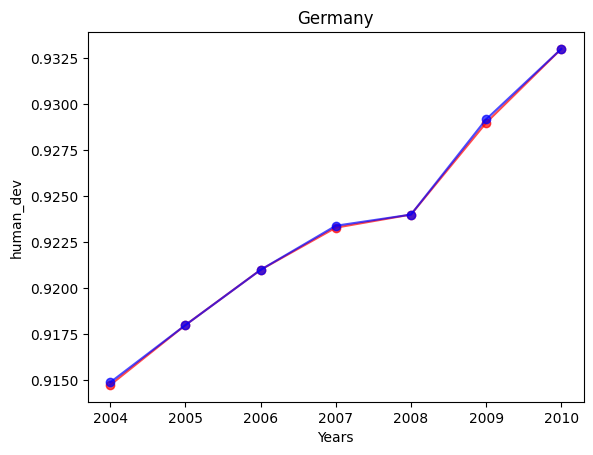

In [ ]:
row = 25

plot_row(denormalized_linear_model, row, collor = 'red', allpha = 0.7)
#plot_row(denormalized_polynomial_model, row, collor = 'green', allpha = 0.7)
#plot_row(denormalized_knn_model, row, collor = 'yellow', allpha = 0.7)
#plot_row(denormalized_zero_model, row, collor = 'purple', allpha = 0.7)
#plot_row(denormalized_mean_model, row, collor = 'orange', allpha = 0.7)
#plot_row(denormalized_master_df, row, collor = 'blue', allpha = 1)

plot_row(denormalized_linear_nn_model, row, collor = 'blue', allpha = 0.7)
#plot_row(denormalized_polynomial_nn_model, row, collor = 'green', allpha = 0.7)
#plot_row(denormalized_knn_nn_model, row, collor = 'yellow', allpha = 0.7)
#plot_row(denormalized_zero_nn_model, row, collor = 'purple', allpha = 0.7)
##plot_row(denormalized_mean_nn_model, row, collor = 'orange', allpha = 0.7)
#plt.ylabel('Murders')

plt.show()

In [ ]:
for i in range(0,500):
  row = i
  plot_row(denormalized_linear_model, row, collor = 'red', allpha = 0.7)
  plot_row(denormalized_polynomial_model, row, collor = 'green', allpha = 0.7)
  plot_row(denormalized_knn_model, row, collor = 'yellow', allpha = 0.7)
  plot_row(denormalized_zero_model, row, collor = 'purple', allpha = 0.7)
  plot_row(denormalized_mean_model, row, collor = 'orange', allpha = 0.7)
  plot_row(denormalized_master_df, row, collor = 'blue', allpha = 1)
#plt.ylabel('Murders')

  plt.show()

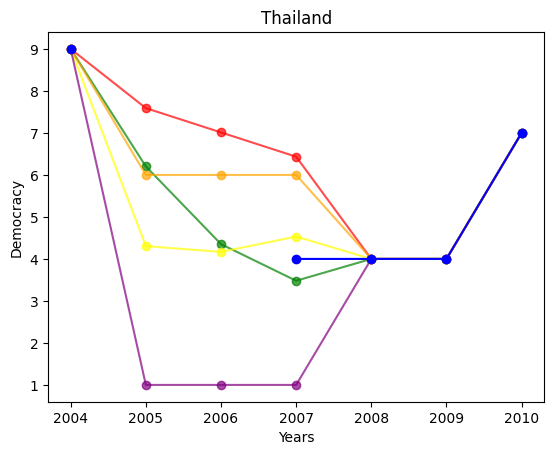

In [ ]:
row = 230
plot_row(denormalized_linear_model, row, collor = 'red', allpha = 0.7)
plot_row(denormalized_polynomial_model, row, collor = 'green', allpha = 0.7)
plot_row(denormalized_knn_model, row, collor = 'yellow', allpha = 0.7)
plot_row(denormalized_zero_model, row, collor = 'purple', allpha = 0.7)
plot_row(denormalized_mean_model, row, collor = 'orange', allpha = 0.7)
plot_row(denormalized_master_df, row, collor = 'blue', allpha = 1)
plt.ylabel('Democracy')
plt.show()